In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR
# import seaborn as sns

import sys
sys.path.append("../")


from historical.readData.old.estimateData3 import read

from historical.readData.old.estimateData3 import read
from historical.readData.old.estimateData3 import search_travels
from historical.readData.old.estimateData3 import estimate
from historical.readData.old.estimateData3 import stops_distance

from historical.readData.old.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second

In [6]:

# if __name__ == '__main__':

selected_line = ['8700-10-1']

# '8700-10-0',
# selected_line = ['8700-10-1',                
#                 '7545-10-1',
#                 '7545-10-0',
#                 '6450-10-1',
#                 '6450-10-0',
#                 '3301-10-1',
# #                 '3301-10-0',
#                 '2290-10-1',
#                 '2290-10-0',
# #                 '574J-10-1',
# #                 '574J-10-0',
# #                 '477P-10-1',
#                 '477P-10-0',
# #                 '351F-10-1',
# #                 '351F-10-0'
#                 ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

line = selected_line[0]
p, mp = stops_distance(line)
pth_files_lines = "../historical/readData/"

### Operação demorada
df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")

df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

In [3]:
start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2017, 7, 1)        

df_training = df.loc[(df['day'] < end_date) & (df['holiday'] != 1) & ((df['weekday'] != 6) | (df['weekday'] != 5))]
df_test = df.loc[(df['day'] >= end_date) & (df['holiday'] != 1) & ((df['weekday'] != 6) | (df['weekday'] != 5))]


/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [4]:

df_training['exact_time'] = np.array(df_training['day'], dtype='datetime64[s]') + \
                       pd.to_timedelta(df_training['start'].apply(hr_func)*60 + \
                       df_training['start'].apply(minute_func) + \
                       df_training['start'].apply(second_func)/60 + \
                       df_training['time'], unit='m')

df_training['day_hour'] = df_training['exact_time'].apply(hr_func)




df_test['exact_time'] = np.array(df_test['day'], dtype='datetime64[s]') + \
                       pd.to_timedelta(df_test['start'].apply(hr_func)*60 + \
                       df_test['start'].apply(minute_func) + \
                       df_test['start'].apply(second_func)/60 + \
                       df_test['time'], unit='m')

df_test['day_hour'] = df_test['exact_time'].apply(hr_func)



/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [5]:
df_training['link'] = 0
df_test['link'] = 0
for i in range(0, len(mp)):
    if (i == 0):
          df_training.loc[df_training.loc[(df_training['distance'] > 0) & (df_training['distance'] < mp[i+1]),]['link'].index,'link'] = i    
    if (i == len(mp) -1):
        df_training.loc[df_training.loc[(df_training['distance'] > mp[i]) & (df_training['distance'] < max(p)),]['link'].index,'link'] = i    
    if (i != 0) & (i != len(mp)-1):
        df_training.loc[df_training.loc[(df_training['distance'] >= mp[i]) & (df_training['distance'] < mp[i+1]),]['link'].index,'link'] = i    

        
    if (i == 0):
          df_test.loc[df_test.loc[(df_test['distance'] > 0) & (df_test['distance'] < mp[i+1]),]['link'].index,'link'] = i    
    if (i == len(mp) -1):
        df_test.loc[df_test.loc[(df_test['distance'] > mp[i]) & (df_test['distance'] < max(p)),]['link'].index,'link'] = i    
    if (i != 0) & (i != len(mp)-1):
        df_test.loc[df_test.loc[(df_test['distance'] >= mp[i]) & (df_test['distance'] < mp[i+1]),]['link'].index,'link'] = i    

        
df_training = df_training.drop_duplicates(subset=['day', 'numtravel', 'link', 'day_hour'])        
df_test = df_test.drop_duplicates(subset=['day', 'numtravel', 'link', 'day_hour'])    

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/marcos/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [6]:
link_df = []
link_df_test =[]

travels = sorted(list(set(df_training.numtravel.unique())))
for tr in travels:
    tck = reps[tr][0]
    tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
    tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
    row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
    link_df.append(row)

travels_test = sorted(list(set(df_test.numtravel.unique())))
for tr in travels_test:
    tck = reps[tr][0]
    tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
    tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
    row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
    link_df_test.append(row)
        

/home/marcos/.local/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:731: RuntimeWarning:

The number of zeros exceeds mest



In [7]:
# data_training['time_link'] = 0 

link_df_np = np.array(link_df)
link_df_np.shape = (np.shape(link_df_np)[0] * np.shape(link_df_np)[2])

right = pd.DataFrame({'numtravel': np.repeat(df_training.numtravel.unique(), len(mp)-1), \
              'link': np.tile(range(0, len(mp)-1), len(df_training.numtravel.unique())), 
              'time_link': link_df_np}) 

data_training = pd.merge(df_training, right, how='left', on=['numtravel', 'link'])


link_df_np_test = np.array(link_df_test)
link_df_np_test.shape = (np.shape(link_df_np_test)[0] * np.shape(link_df_np_test)[2])

right = pd.DataFrame({'numtravel': np.repeat(df_test.numtravel.unique(), len(mp)-1), \
              'link': np.tile(range(0, len(mp)-1), len(df_test.numtravel.unique())), 
              'time_link': link_df_np_test}) 

data_test = pd.merge(df_test, right, how='left', on=['numtravel', 'link'])


In [8]:
data_training.loc[(data_training['time_link'] > 5),'time_link'] = np.ceil(data_training['time_link'].mean())
data_test.loc[(data_test['time_link'] > 5),'time_link'] = np.ceil(data_test['time_link'].mean())



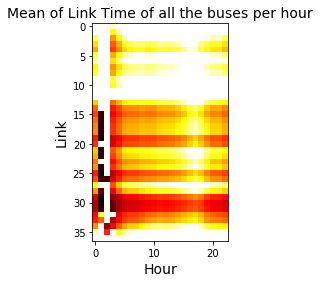

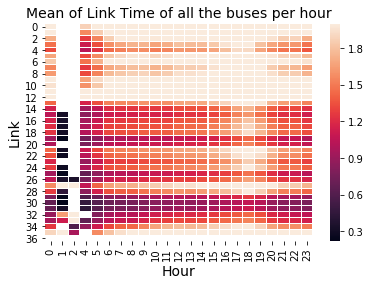

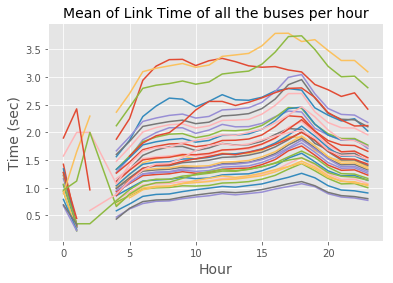

In [9]:

data_training.groupby(['link', 'day_hour'])['time_link'].mean()
# pd.unique(df_training[['day', 'link']].values)
# df_training.unique(['day'])

# ax = plt.subplot(1,1, 1)
plot_df = (data_training.groupby(['link', 'day_hour']).mean()).unstack('day_hour').loc[:, 'time_link']


plt.imshow(plot_df, cmap='hot', vmax=2, interpolation='nearest')
plt.title('Mean of Link Time of all the buses per hour',fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Link',fontsize=14)
plt.show()


ax = sns.heatmap(plot_df, vmax=2, linewidth=0.05)
plt.title('Mean of Link Time of all the buses per hour',fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Link',fontsize=14)
plt.show()

plt.figure()
plt.style.use('ggplot')
plt.plot(data_training.groupby(['day_hour', 'link'])['time_link'].mean().unstack())
plt.title('Mean of Link Time of all the buses per hour',fontsize=14)
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Time (sec)',fontsize=14)
plt.show()
# plot_df.index = pd.PeriodIndex(plot_df.index.tolist(), freq='A')
# plot_df.plot()

### Temporal Covariance

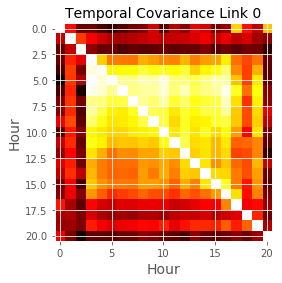

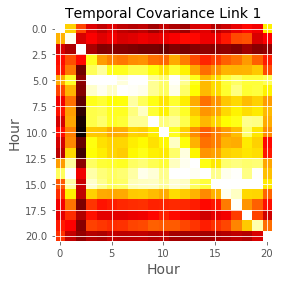

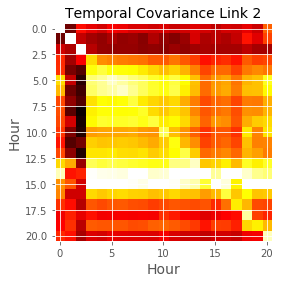

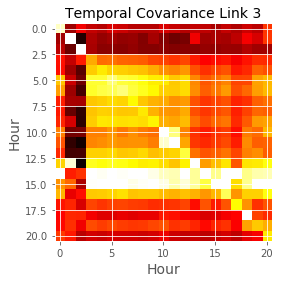

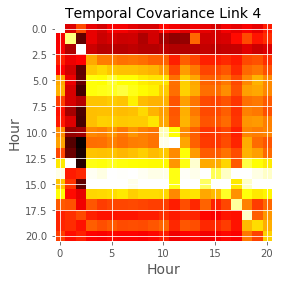

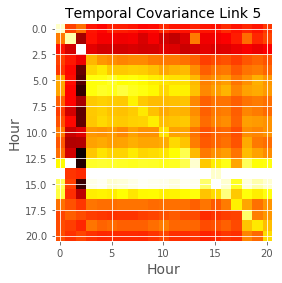

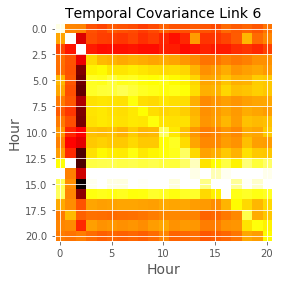

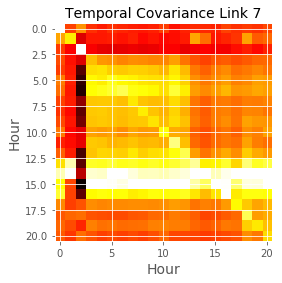

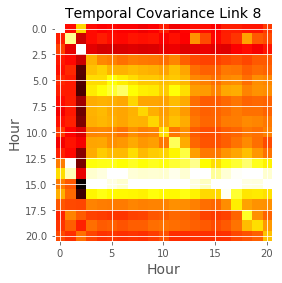

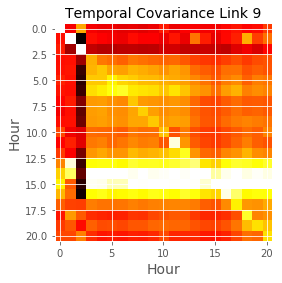

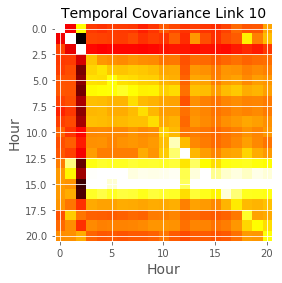

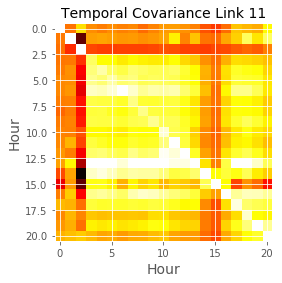

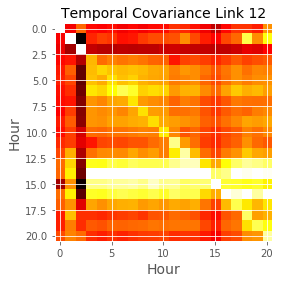

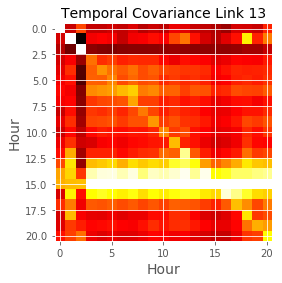

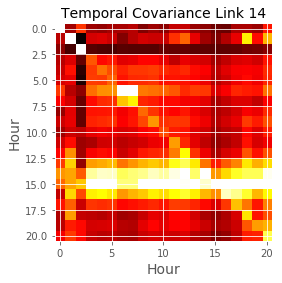

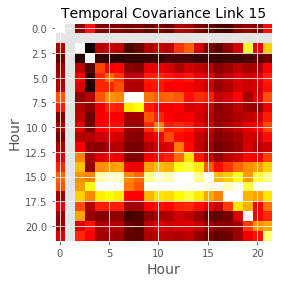

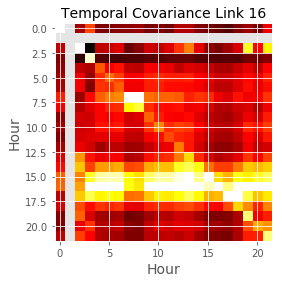

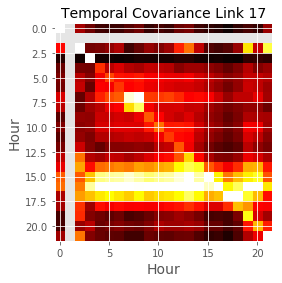

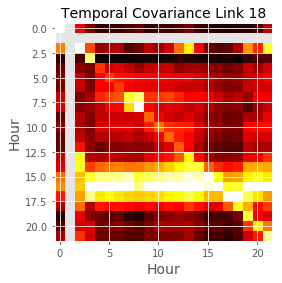

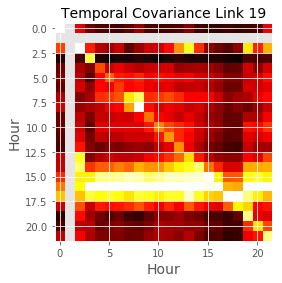

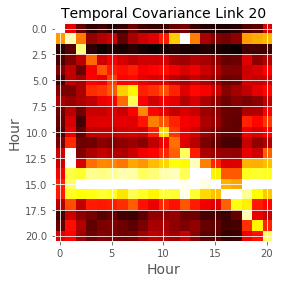

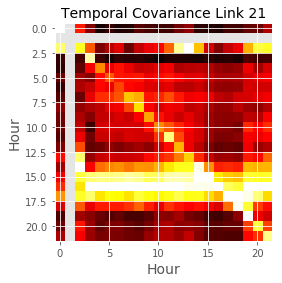

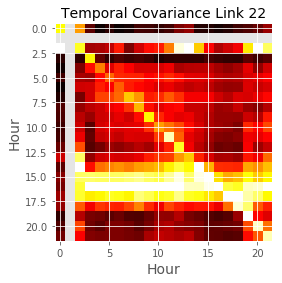

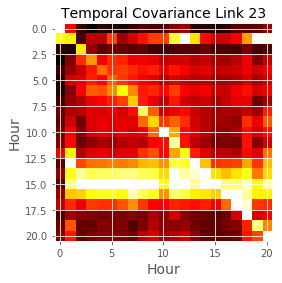

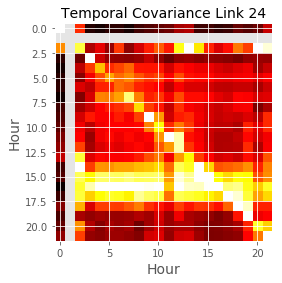

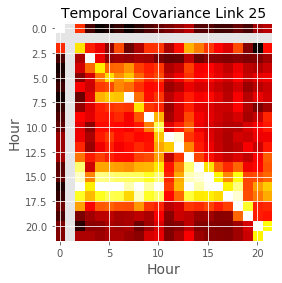

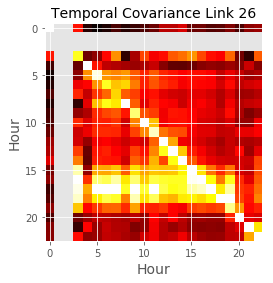

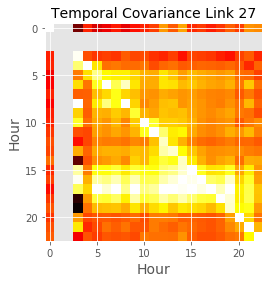

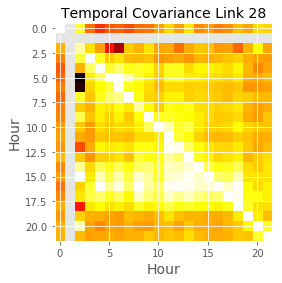

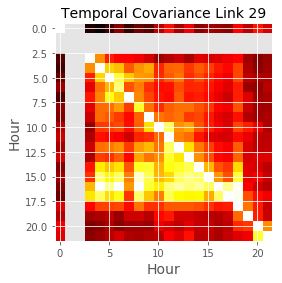

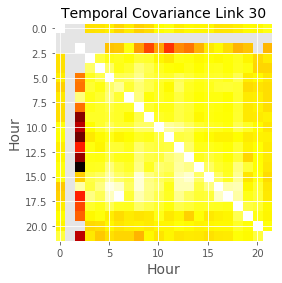

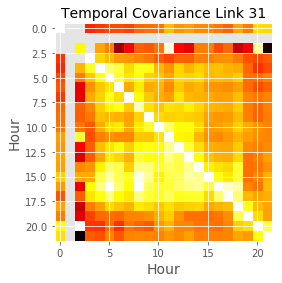

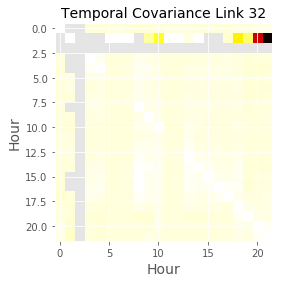

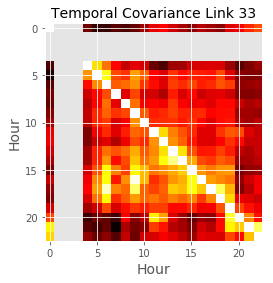

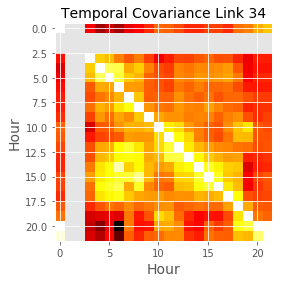

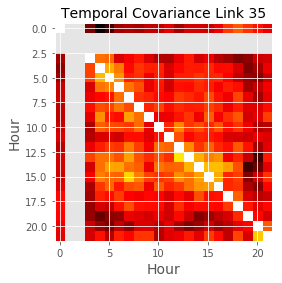

In [10]:
for link in range(0,len(mp)-1):
    dt_mean = data_training.loc[(data_training['link'] == link)]\
                        .groupby(['day', 'day_hour'], as_index=True )['day', 'time_link'].mean().unstack()
    
    plt.imshow(dt_mean.cov().transform(lambda x: x / x.max()), cmap='hot', interpolation='nearest')
    plt.title('Temporal Covariance Link ' + str(link),fontsize=14)
    plt.xlabel('Hour',fontsize=14)
    plt.ylabel('Hour',fontsize=14)
    plt.show()
    

### Spatial covariance

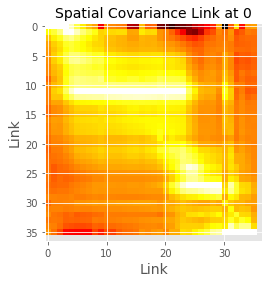

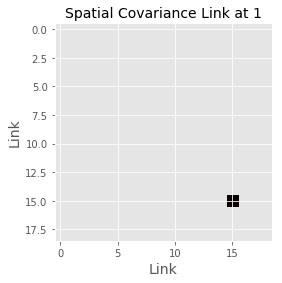

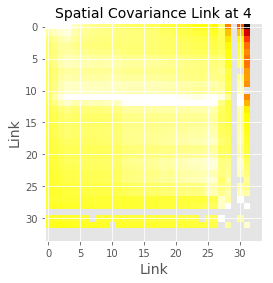

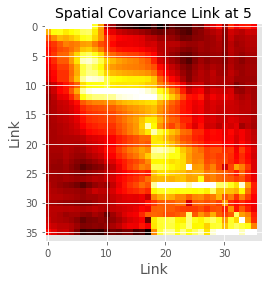

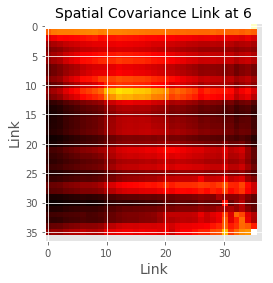

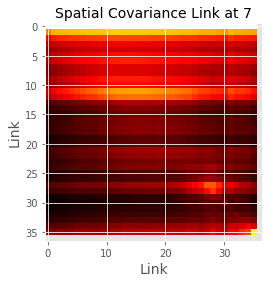

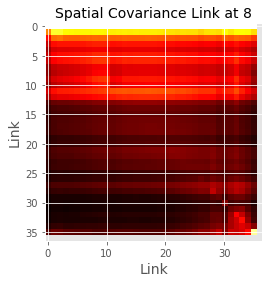

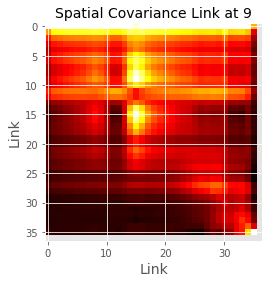

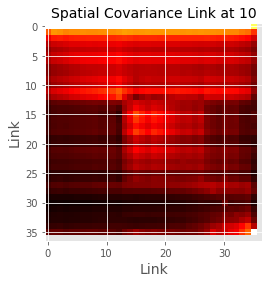

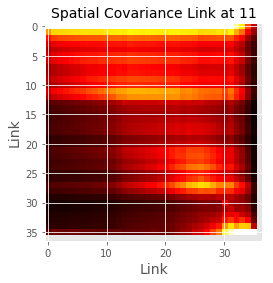

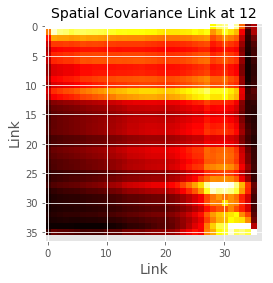

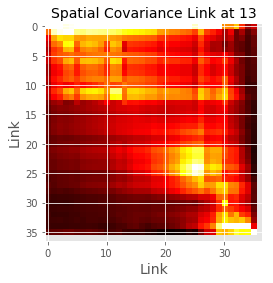

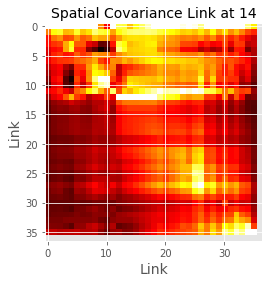

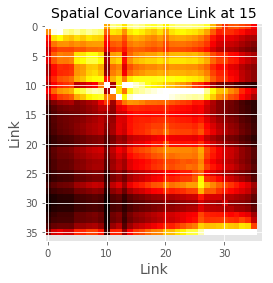

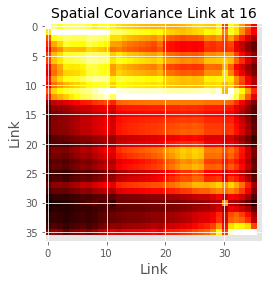

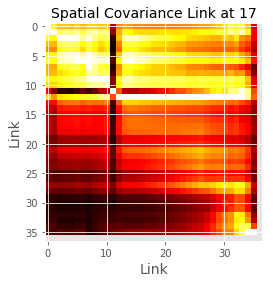

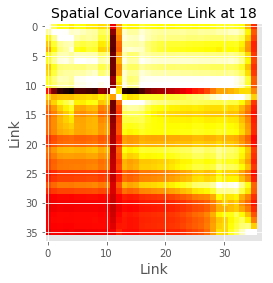

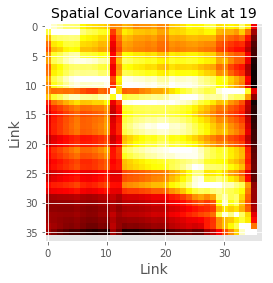

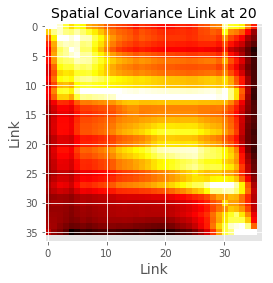

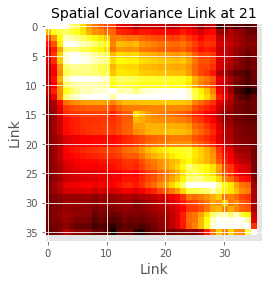

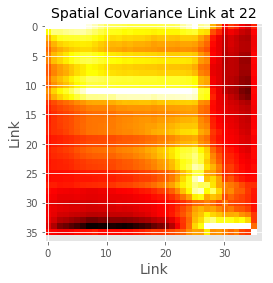

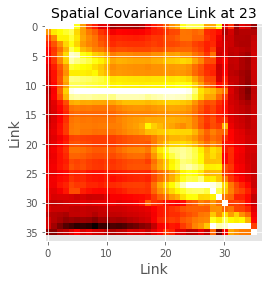

In [11]:
for day_hour in range(0,24):
    dt_mean = data_training.loc[(data_training['day_hour'] == day_hour)]\
                        .groupby(['day', 'link'], as_index=True )['time_link'].mean().unstack()
    
    if (day_hour != 2) & (day_hour != 3):                    
        plt.imshow(dt_mean.cov().transform(lambda x: x/x.max()), cmap='hot', interpolation='nearest')
        plt.title('Spatial Covariance Link at ' + str(day_hour),fontsize=14)
        plt.xlabel('Link',fontsize=14)
        plt.ylabel('Link',fontsize=14)
        plt.show()


## Temporal Correlation

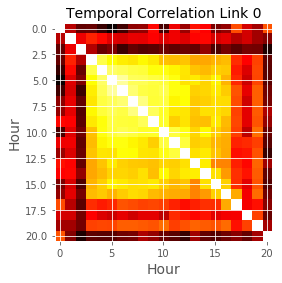

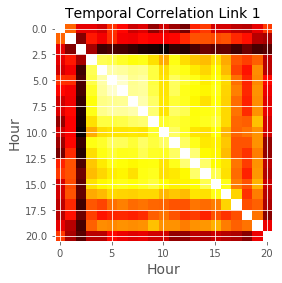

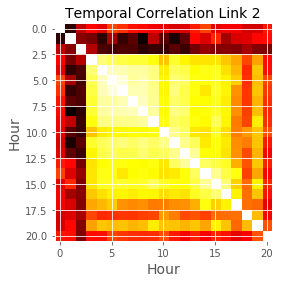

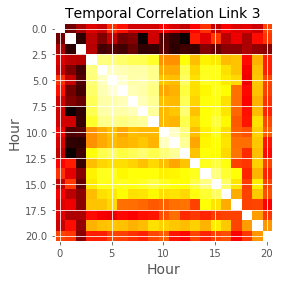

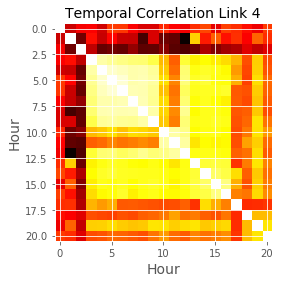

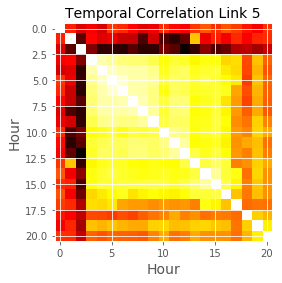

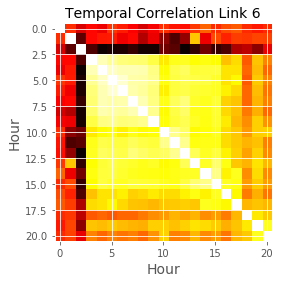

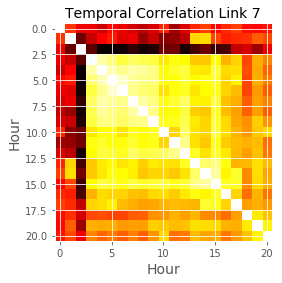

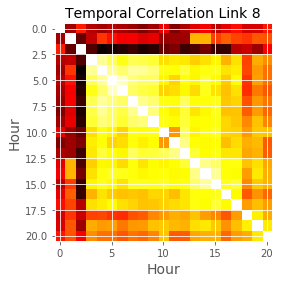

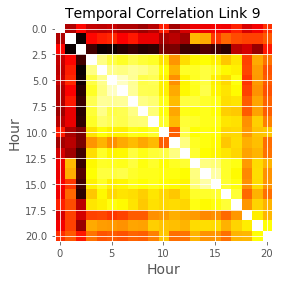

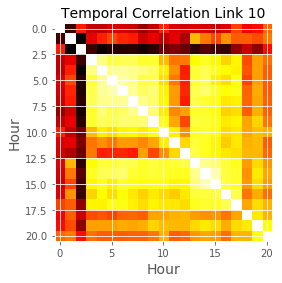

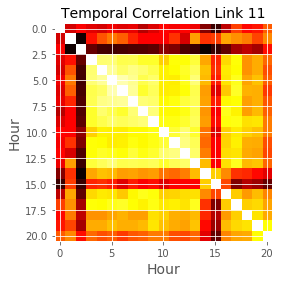

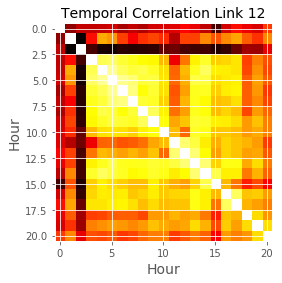

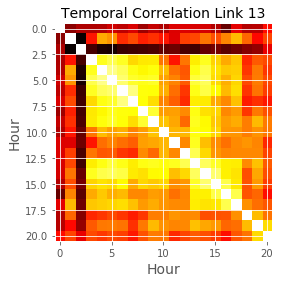

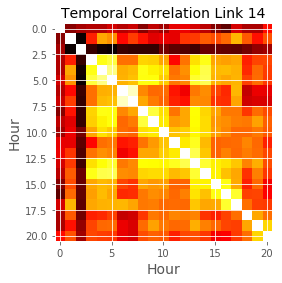

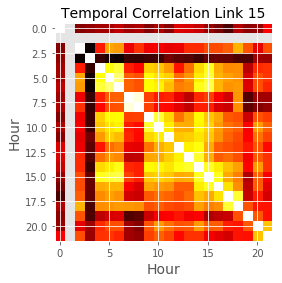

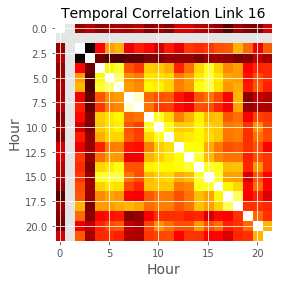

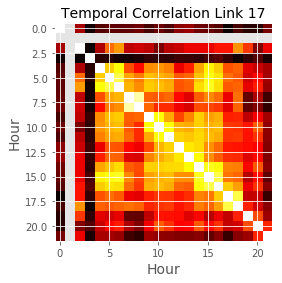

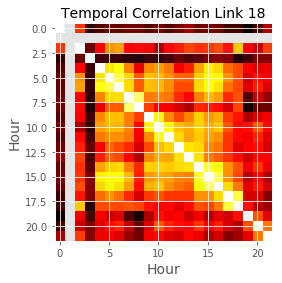

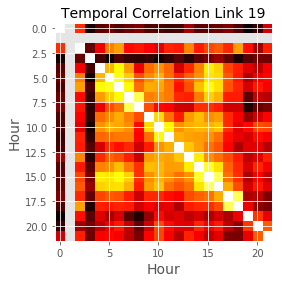

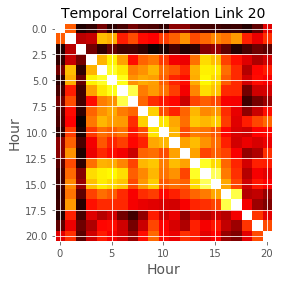

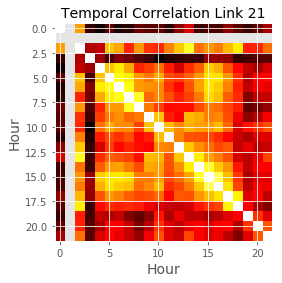

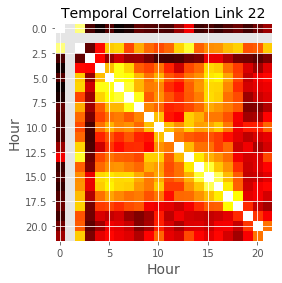

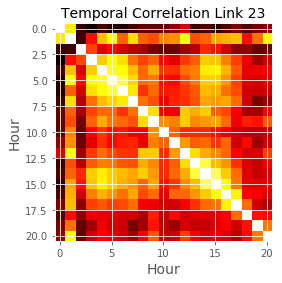

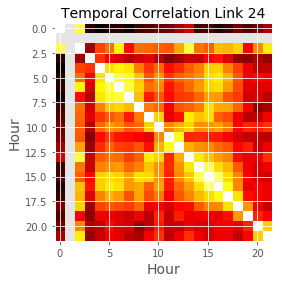

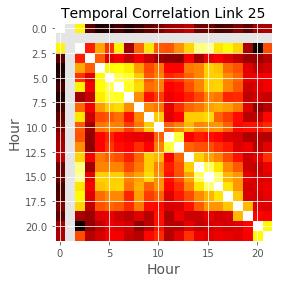

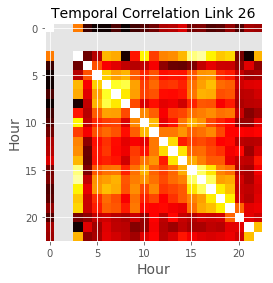

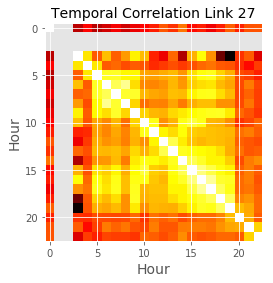

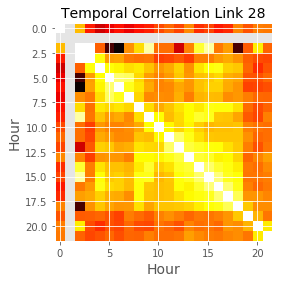

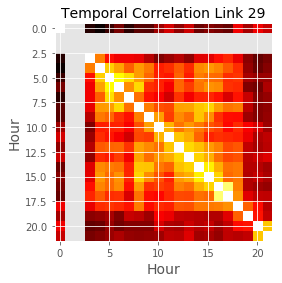

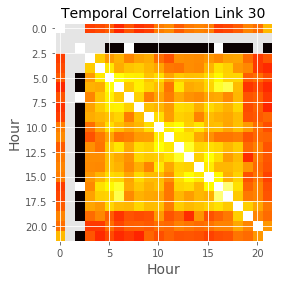

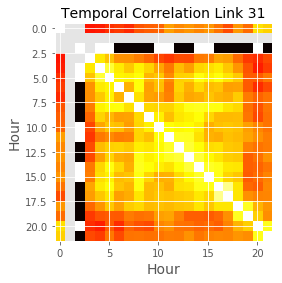

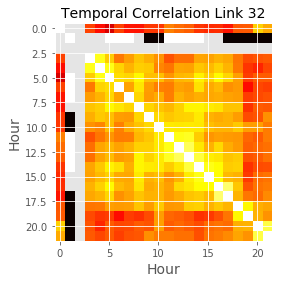

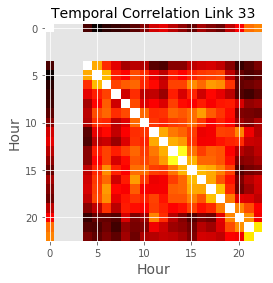

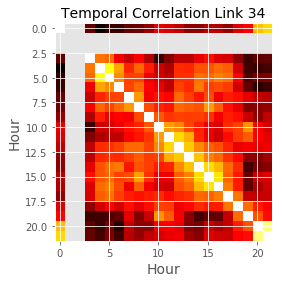

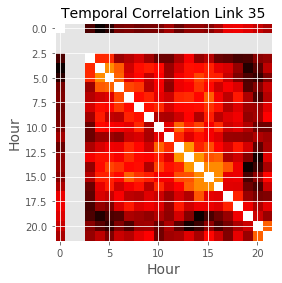

In [12]:
for link in range(0,len(mp)-1):
    dt_mean = data_training.loc[(data_training['link'] == link)]\
                        .groupby(['day', 'day_hour'], as_index=True )['day', 'time_link'].mean().unstack()
    
    plt.imshow(dt_mean.corr().transform(lambda x: x/x.max()), cmap='hot', interpolation='nearest')
    plt.title('Temporal Correlation Link ' + str(link),fontsize=14)
    plt.xlabel('Hour',fontsize=14)
    plt.ylabel('Hour',fontsize=14)    
    plt.show()

    

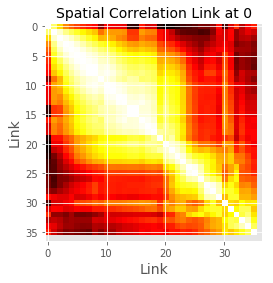

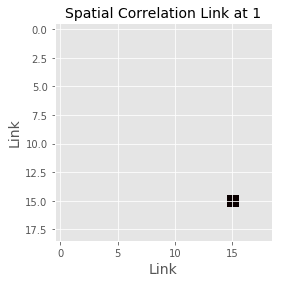

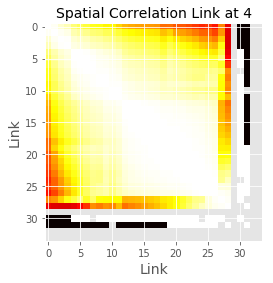

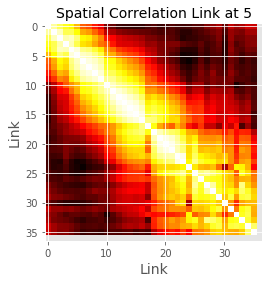

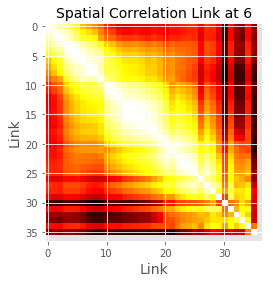

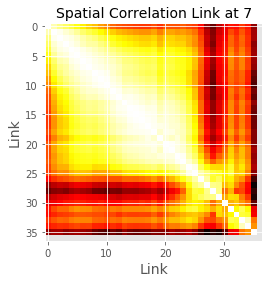

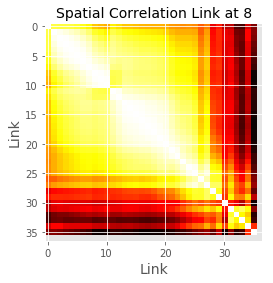

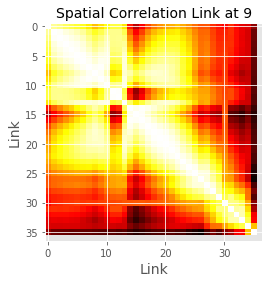

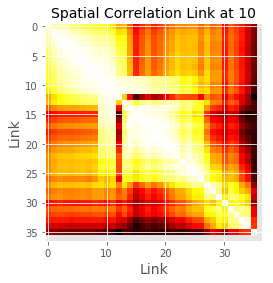

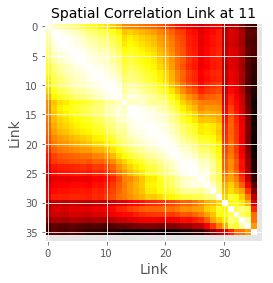

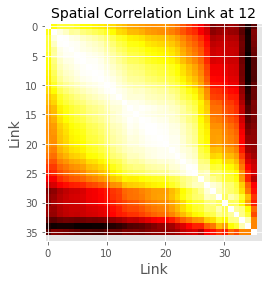

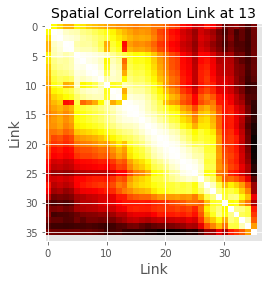

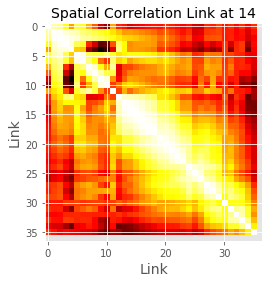

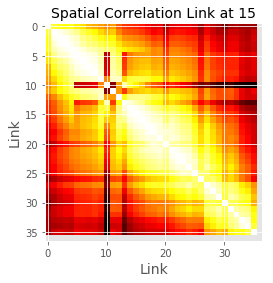

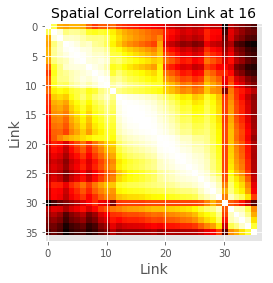

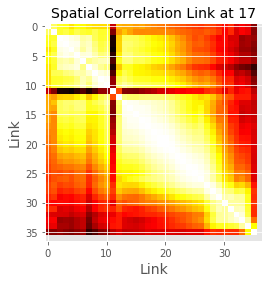

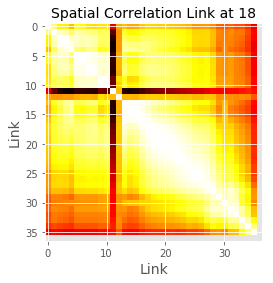

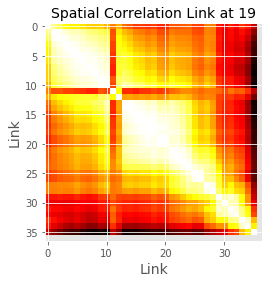

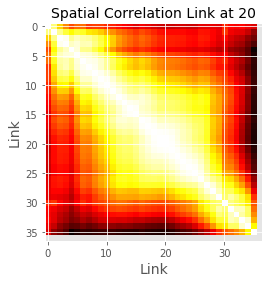

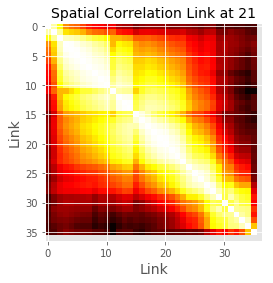

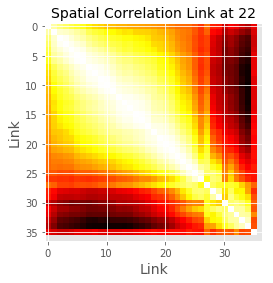

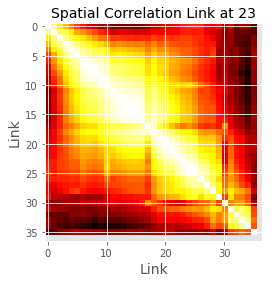

In [13]:
for day_hour in range(0,24):
    dt_mean = data_training.loc[(data_training['day_hour'] == day_hour)]\
                        .groupby(['day', 'link'], as_index=True )['time_link'].mean().unstack()
    
    if (day_hour != 2) & (day_hour != 3):

        plt.imshow(dt_mean.corr().transform(lambda x: x/x.max()), cmap='hot', interpolation='nearest')
        plt.title('Spatial Correlation Link at ' + str(day_hour),fontsize=14)
        plt.xlabel('Link',fontsize=14)
        plt.ylabel('Link',fontsize=14)
        plt.show()
